# 패키지 임포드

In [4]:
import os
import json
import shutil
import chardet
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# 데이터 기초 처리

데이터를 추가로 다운 받았을떄 사용

## 이미지 파일 폴더 하나에 모으기

In [ ]:
def collect_png_files(source_dir, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    
    for root, _, files in os.walk(source_dir):
        for file in files:
            if file.endswith(".png") and "index" not in file:
                source_path = os.path.join(root, file)
                destination_path = os.path.join(destination_dir, file)
                
                # 파일이 존재하면 덮어쓰기
                shutil.copy2(source_path, destination_path)
                print(f"복사 완료: {destination_path}")

source_directory = r""  # 원본 폴더 경로 설정
destination_directory = "../data/train_images"  # 파일을 저장할 폴더 경로 설정

collect_png_files(source_directory, destination_directory)

## 손상된 이미지 삭제

In [ ]:
def find_and_remove_corrupt_images(root_folder):
    corrupt_files = []

    for dirpath, _, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
                file_path = os.path.join(dirpath, filename)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # 파일이 정상적으로 열리는지 확인
                except (IOError, SyntaxError):
                    print(f"손상된 파일 발견 및 삭제: {file_path}")
                    corrupt_files.append(file_path)
                    os.remove(file_path)  # 파일 삭제

    return corrupt_files

# 사용 예제
image_root_directory = "../data/train_images"  # 이미지 파일이 있는 최상위 폴더 경로 설정
corrupt_images = find_and_remove_corrupt_images(image_root_directory)

if corrupt_images:
    print("\n삭제된 손상된 이미지 파일 목록:")
    for corrupt_file in corrupt_images:
        print(corrupt_file)
else:
    print("\n손상된 이미지가 없습니다.")

## json 파일 수정

In [ ]:
def detect_encoding(file_path):
    """파일의 인코딩을 감지하는 함수"""
    with open(file_path, "rb") as f:
        raw_data = f.read(100000)  # 일부 데이터만 읽어 인코딩 감지
        result = chardet.detect(raw_data)
        return result["encoding"] if result["encoding"] else None

def fix_json_files(root_folder, start_id=1490):
    file_id_map = {}  # file_name을 기준으로 ID 매핑 저장
    current_id = start_id

    for dirpath, _, filenames in os.walk(root_folder):  # 모든 하위 폴더 탐색
        for filename in filenames:
            if filename.endswith(".json"):
                file_path = os.path.join(dirpath, filename)

                # 인코딩 감지
                encoding = detect_encoding(file_path)

                # UTF-8이 아니면 파일 삭제
                if encoding is None or encoding.lower() not in ["utf-8", "ascii"]:
                    print(f"UTF-8이 아님 -> 파일 삭제: {file_path} (감지된 인코딩: {encoding})")
                    os.remove(file_path)
                    continue

                # JSON 파일 로드
                try:
                    with open(file_path, "r", encoding="utf-8") as file:
                        data = json.load(file)
                except (UnicodeDecodeError, json.JSONDecodeError):
                    print(f"JSON 오류 발생 -> 파일 삭제: {file_path}")
                    os.remove(file_path)
                    continue  # 오류 발생 시 해당 파일 삭제 후 다음으로 진행

                if "images" in data and "annotations" in data and "categories" in data:
                    images_info = {}  # image id 매핑용 임시 딕셔너리
                    category_map = {}  # 카테고리 정보 저장
                    new_categories = []

                    # images의 id를 file_name 기준으로 통일
                    for image in data["images"]:
                        file_name = image["file_name"]
                        if file_name in file_id_map:
                            new_id = file_id_map[file_name]
                        else:
                            new_id = current_id
                            file_id_map[file_name] = current_id
                            current_id += 1

                        image["id"] = new_id  # 새로운 ID 할당
                        images_info[image["id"]] = image  # 매핑 저장

                    # annotations의 image_id 업데이트
                    for annotation in data["annotations"]:
                        old_image_id = annotation["image_id"]
                        if old_image_id in images_info:
                            annotation["image_id"] = images_info[old_image_id]["id"]
                            annotation["category_id"] = int(images_info[old_image_id]["dl_idx"])  # category_id 수정

                    # categories 정보 업데이트
                    for image in data["images"]:
                        dl_idx = int(image["dl_idx"])
                        dl_name = image["dl_name"]

                        if dl_idx not in category_map:
                            category_map[dl_idx] = dl_name
                            new_categories.append({
                                "supercategory": "pill",
                                "id": dl_idx,
                                "name": dl_name
                            })

                    data["categories"] = new_categories  # 업데이트된 categories 반영

                    # 수정된 JSON 파일 저장
                    with open(file_path, "w", encoding="utf-8") as file:
                        json.dump(data, file, indent=4, ensure_ascii=False)

                    print(f"수정 완료: {file_path}")

json_root_directory = "../data/train_annotations"  # 최상위 폴더 경로 설정
fix_json_files(json_root_directory)

## 매칭되는 이미지가 없는 json 삭제

In [62]:
def remove_invalid_json(annotation_folder, image_folder):
    deleted_jsons = []

    for dirpath, _, filenames in os.walk(annotation_folder):  # 주석 파일 탐색
        for filename in filenames:
            if filename.endswith(".json"):
                file_path = os.path.join(dirpath, filename)

                # JSON 파일 로드
                with open(file_path, "r", encoding="utf-8") as file:
                    try:
                        data = json.load(file)
                    except json.JSONDecodeError:
                        print(f"잘못된 JSON 파일 발견 및 삭제: {file_path}")
                        os.remove(file_path)
                        deleted_jsons.append(file_path)
                        continue

                if "images" not in data:
                    print(f"'images' 키 없음 -> JSON 삭제: {file_path}")
                    os.remove(file_path)
                    deleted_jsons.append(file_path)
                    continue

                # 이미지 파일 존재 여부 확인
                all_images_exist = True
                for image in data["images"]:
                    image_path = os.path.join(image_folder, image["file_name"])
                    if not os.path.exists(image_path):  # 이미지 파일이 없으면 JSON 삭제
                        print(f"해당 이미지 없음 -> JSON 삭제: {file_path}")
                        os.remove(file_path)
                        deleted_jsons.append(file_path)
                        all_images_exist = False
                        break  # 하나라도 없으면 삭제 후 반복 종료

                if all_images_exist:
                    print(f"유효한 JSON 파일 유지: {file_path}")

    return deleted_jsons

# 사용 예제
annotation_root = "../data/train_annotations"  # 주석 파일(JSON) 폴더 경로
image_root = "../data/train_images"  # 이미지가 저장된 폴더 경로

deleted_files = remove_invalid_json(annotation_root, image_root)

if deleted_files:
    print("\n삭제된 JSON 파일 목록:")
    for deleted in deleted_files:
        print(deleted)
else:
    print("\n모든 JSON 파일이 유효합니다.")

해당 이미지 없음 -> JSON 삭제: ../data/train_annotations\K-000250-000573-002483-006192_json\K-000250\K-000250-000573-002483-006192_0_2_0_2_70_000_200.json
해당 이미지 없음 -> JSON 삭제: ../data/train_annotations\K-000250-000573-002483-006192_json\K-000250\K-000250-000573-002483-006192_0_2_0_2_75_000_200.json
해당 이미지 없음 -> JSON 삭제: ../data/train_annotations\K-000250-000573-002483-006192_json\K-000250\K-000250-000573-002483-006192_0_2_0_2_90_000_200.json
해당 이미지 없음 -> JSON 삭제: ../data/train_annotations\K-000250-000573-002483-006192_json\K-000573\K-000250-000573-002483-006192_0_2_0_2_70_000_200.json
해당 이미지 없음 -> JSON 삭제: ../data/train_annotations\K-000250-000573-002483-006192_json\K-000573\K-000250-000573-002483-006192_0_2_0_2_75_000_200.json
해당 이미지 없음 -> JSON 삭제: ../data/train_annotations\K-000250-000573-002483-006192_json\K-000573\K-000250-000573-002483-006192_0_2_0_2_90_000_200.json
해당 이미지 없음 -> JSON 삭제: ../data/train_annotations\K-000250-000573-002483-006192_json\K-002483\K-000250-000573-002483-006192_0_

## Annotations to CSV

In [ ]:
# 파일 이름에서 알약 개수 추출
def extract_pill_count(file_name):
    try:
        base_name = file_name.split("_")[0]  
        number_parts = base_name[1:].split("-")  
        return len(number_parts[1:])
    except:
        return -1  

def remap_category_ids(df):
    """
    category_id를 0부터 연속적인 정수 값으로 변환하는 함수.

    Args:
        df (pd.DataFrame): 원본 데이터프레임

    Returns:
        pd.DataFrame: category_id가 재매핑된 데이터프레임
        dict: 원래 category_id -> 새로운 ID 매핑 딕셔너리
    """
    unique_categories = sorted(set(df["category_id"]))  # 고유 category_id 정렬
    category_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_categories)}

    # 기존 category_id를 새로운 new_category_id로 변환
    df["category_id"] = df["category_id"].map(category_mapping)
    return df, category_mapping

# 데이터가 저장된 폴더 경로
root_dir = "../data/train_annotations"
image_root_dir = "../data/train_images"

# JSON 데이터를 저장할 리스트
image_data = []
annotation_data = []

# 각 폴더를 순회하며 데이터 수집
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    
    if os.path.isdir(folder_path):
        for drug_folder in os.listdir(folder_path):
            drug_folder_path = os.path.join(folder_path, drug_folder)
            
            if os.path.isdir(drug_folder_path):
                for json_file in os.listdir(drug_folder_path):
                    if json_file.endswith(".json"):
                        json_path = os.path.join(drug_folder_path, json_file)

                        with open(json_path, "r", encoding="utf-8") as f:
                            data = json.load(f)

                        # 이미지 정보 저장
                        for img in data["images"]:
                            img_path = os.path.join(image_root_dir, img["file_name"])

                            # dl_idx를 숫자로 변환
                            try:
                                dl_idx_numeric = int(img["dl_idx"])
                            except (ValueError, TypeError):
                                dl_idx_numeric = -1

                            image_data.append({
                                "file_name": img["file_name"],
                                "image_id": img["id"],
                                "width": img["width"],
                                "height": img["height"],
                                "drug_name": img.get("dl_name", "Unknown"),
                                "drug_material": img.get("dl_material", "Unknown"),
                                "company": img.get("dl_company", "Unknown"),
                                "dl_idx": dl_idx_numeric
                            })

                        # 주석 정보 저장
                        for ann in data["annotations"]:
                            annotation_data.append({
                                "image_id": ann["image_id"],
                                "bbox": tuple(ann["bbox"]),
                                "area": ann["area"],
                                "category_id": ann["category_id"]
                            })

# 데이터프레임 변환
df_images = pd.DataFrame(image_data)
df_annotations = pd.DataFrame(annotation_data)

# 이미지와 주석을 병합
df_merged = df_images.merge(df_annotations, on=["image_id"], how="inner")

# category_id와 dl_idx가 같은 경우만 유지
df_filtered = df_merged[df_merged["category_id"] == df_merged["dl_idx"]].copy()

df_filtered.loc[:, "pill_count"] = df_filtered["file_name"].apply(extract_pill_count)

# image_id별 category_id 개수 계산
df_category_count = df_filtered.groupby("image_id")["category_id"].count().reset_index()
df_category_count.rename(columns={"category_id": "category_count"}, inplace=True)

# 데이터 병합
df_filtered = df_filtered.merge(df_category_count, on="image_id", how="left")
df_filtered = df_filtered[df_filtered["category_count"] == df_filtered["pill_count"]]

df_filtered, category_mapping = remap_category_ids(df_filtered)

# category_id ↔ drug_name 매핑 생성
category_name_mapping = df_filtered.groupby("category_id")["drug_name"].first().to_dict()

# 데이터 그룹화
df_grouped = df_filtered.groupby("image_id", sort=False).agg({
    "file_name": "first",
    "width": "first",
    "height": "first",
    "drug_name": lambda x: list(x),  
    "drug_material": lambda x: list(x),  
    "company": lambda x: list(x),  
    "dl_idx": lambda x: list(x),  
    "category_id": lambda x: list(x),  
    "bbox": lambda x: list(x),  
    "area": lambda x: list(x),  
    "pill_count": "first",
    "category_count": "first"
}).reset_index()

# `dl_idx`를 기준으로 모든 리스트 컬럼 정렬
sorted_lists = df_grouped.apply(lambda row: list(zip(*sorted(zip(
    row["dl_idx"], row["category_id"], row["drug_name"], row["bbox"], row["area"]
), key=lambda x: x[0]))), axis=1)

# 개별 컬럼에 다시 저장 (순서 일치)
df_grouped["dl_idx"] = sorted_lists.apply(lambda x: list(x[0]))
df_grouped["category_id"] = sorted_lists.apply(lambda x: list(x[1]))
df_grouped["drug_name"] = sorted_lists.apply(lambda x: list(x[2]))
df_grouped["bbox"] = sorted_lists.apply(lambda x: list(x[3]))
df_grouped["area"] = sorted_lists.apply(lambda x: list(x[4]))

def compute_iou(box1, box2):
    """ 두 바운딩 박스의 IoU 계산 """
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # 교차 영역 좌표
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    # 교차 영역 너비 및 높이
    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    inter_area = inter_width * inter_height

    # 각 박스의 영역
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # IoU 계산
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def filter_invalid_and_overlapping_bboxes(df, iou_threshold=0.7):
    """
    1) bbox의 크기가 4개가 아닌 경우 삭제
    2) bbox들 간 IoU가 특정 threshold 이상이면 중복으로 판단하고 삭제
    """
    invalid_indices = []

    for i in df.index:
        bboxes = df.at[i, "bbox"]  # 해당 이미지의 bbox 리스트

        # 1️bbox의 크기가 4개가 아닌 경우 삭제
        if any(len(bbox) != 4 for bbox in bboxes):
            invalid_indices.append(i)
            continue  # 이미 삭제할 예정이므로 중복 체크할 필요 없음

        # 2️IoU 기반 중복 bbox 제거
        num_bboxes = len(bboxes)
        for j in range(num_bboxes):
            for k in range(j + 1, num_bboxes):
                if compute_iou(bboxes[j], bboxes[k]) > iou_threshold:
                    invalid_indices.append(i)  # 겹치는 경우 삭제
                    break
            if i in invalid_indices:  # 중복 확인 후 다음 행으로 이동
                break

    # 중복 제거 후 삭제
    invalid_indices = list(set(invalid_indices))
    df.drop(index=invalid_indices, inplace=True)
    return df

# 적용
df_grouped = filter_invalid_and_overlapping_bboxes(df_grouped, iou_threshold=0.7)

# 카테고리 매핑을 JSON으로 저장 (원래 ID → 새로운 ID)
with open("../data/category_mapping.json", "w", encoding="utf-8") as f:
    json.dump(category_mapping, f, ensure_ascii=False, indent=4)

# JSON 파일로 저장
output_json_path2 = "../data/category_name_mapping.json"
with open(output_json_path2, "w", encoding="utf-8") as f:
    json.dump(category_name_mapping, f, ensure_ascii=False, indent=4, sort_keys=True)

# CSV 저장
df_grouped.to_csv("../data/image_annotations.csv", index=False, encoding="utf-8-sig")

# 결과 출력
print(df_grouped.shape)
df_grouped.head()

(2058, 13)


image_id                                          file_name  width  height  \
0      1501  K-000250-000573-002483-022627_0_2_0_2_90_000_2...    976    1280   
1      1502  K-000250-000573-002483-023223_0_2_0_2_70_000_2...    976    1280   
2      1503  K-000250-000573-002483-023223_0_2_0_2_75_000_2...    976    1280   
3      1504  K-000250-000573-002483-023223_0_2_0_2_90_000_2...    976    1280   
4      1505  K-000250-000573-005002-006192_0_2_0_2_70_000_2...    976    1280   

                                           drug_name  \
0  [마그밀정(수산화마그네슘), 게보린정 300mg/PTP, 뮤테란캡슐 100mg, 메...   
1  [마그밀정(수산화마그네슘), 게보린정 300mg/PTP, 뮤테란캡슐 100mg, 비...   
2  [마그밀정(수산화마그네슘), 게보린정 300mg/PTP, 뮤테란캡슐 100mg, 비...   
3  [마그밀정(수산화마그네슘), 게보린정 300mg/PTP, 뮤테란캡슐 100mg, 비...   
4  [마그밀정(수산화마그네슘), 게보린정 300mg/PTP, 엘도스캡슐(에르도스테인)(...   

                                       drug_material  \
0     [수산화마그네슘, 아세트아미노펜|카페인무수물|이소프로필안티피린, 아세틸시스테인, ]   
1  [수산화마그네슘, 아세트아미노펜|카페인무수물|이소프로필안티피린, 아세틸시스테인, 니...   
2  [수산화마그네슘, 아세트아미노펜|카페인무수물|이소프로필안티피린, 아세틸시스테인, 니...   
3  [수산화마그네슘, 아세트아미노펜|카페인무수물|이소프로필안티피린, 아세틸시스테인, 니...   
4  [수산화마그네슘, 아세트아미노펜|카페인무수물|이소프로필안티피린, 에르도스테인, 아스...   

                                company                   dl_idx  \
0  [삼남제약(주), 삼진제약(주), 한화제약(주), (주)유한양행]  [249, 572, 2482, 22626]   
1  [삼남제약(주), 삼진제약(주), 한화제약(주), (주)유한양행]  [249, 572, 2482, 23222]   
2  [삼남제약(주), 삼진제약(주), 한화제약(주), (주)유한양행]  [249, 572, 2482, 23222]   
3  [삼남제약(주), 삼진제약(주), 한화제약(주), (주)유한양행]  [249, 572, 2482, 23222]   
4  [삼남제약(주), 삼진제약(주), (주)대웅제약, (주)유한양행]   [249, 572, 5001, 6191]   

      category_id                                               bbox  \
0   [0, 1, 4, 47]  [(103, 804, 279, 282), (571, 767, 303, 290), (...   
1   [0, 1, 4, 49]  [(550, 182, 276, 279), (69, 190, 304, 296), (6...   
2   [0, 1, 4, 49]  [(101, 816, 290, 296), (580, 764, 308, 304), (...   
3   [0, 1, 4, 49]  [(103, 803, 278, 282), (571, 767, 303, 289), (...   
4  [0, 1, 12, 15]  [(538, 183, 273, 277), (58, 195, 302, 296), (4...   

                             area  pill_count  category_count  
0  [78678, 87870, 135432, 166782]           4               4  
1  [77004, 89984, 134815, 165998]           4               4  
2  [85840, 93632, 129064, 155472]           4               4  
3  [78396, 87567, 134225, 167528]           4               4  
4  [75621, 89392, 129541, 187616]           4               4

## json이 완전하지 않은 이미지 삭제

In [60]:
import os

# 이미지가 저장된 폴더 경로
image_folder = "../data/train_images"

# 데이터프레임에 있는 이미지 파일명 목록 (집합으로 저장하여 검색 속도 향상)
valid_filenames = set(df_grouped["file_name"])

# 폴더 내 모든 이미지 파일 확인
for filename in os.listdir(image_folder):
    file_path = os.path.join(image_folder, filename)

    # 파일이 이미지이고, 데이터프레임에 존재하지 않는 경우 삭제
    if os.path.isfile(file_path) and filename not in valid_filenames:
        os.remove(file_path)
        print(f"삭제됨: {file_path}")

print("정리 완료: 데이터프레임에 없는 이미지가 삭제되었습니다.")

정리 완료: 데이터프레임에 없는 이미지가 삭제되었습니다.


# 데이터 EDA

## 클래스 확인

In [48]:
num_classes = df_grouped["drug_name"].explode().nunique()
print(f"총 클래스 개수: {num_classes}")

총 클래스 개수: 82


In [49]:
class_counts = df_grouped["drug_name"].explode().value_counts()
print("클래스별 개수:\n", class_counts)

클래스별 개수:
 drug_name
알마겔정(알마게이트)(수출명:유한가스트라겔정)    534
마그밀정(수산화마그네슘)                511
게보린정 300mg/PTP               434
뮤테란캡슐 100mg                  296
다보타민큐정 10mg/병                285
                            ... 
쿠에타핀정 25mg                     6
졸로푸트정 100mg                    6
자이프렉사정 2.5mg                   4
렉사프로정 15mg                     3
브린텔릭스정 20mg                    3
Name: count, Length: 82, dtype: int64


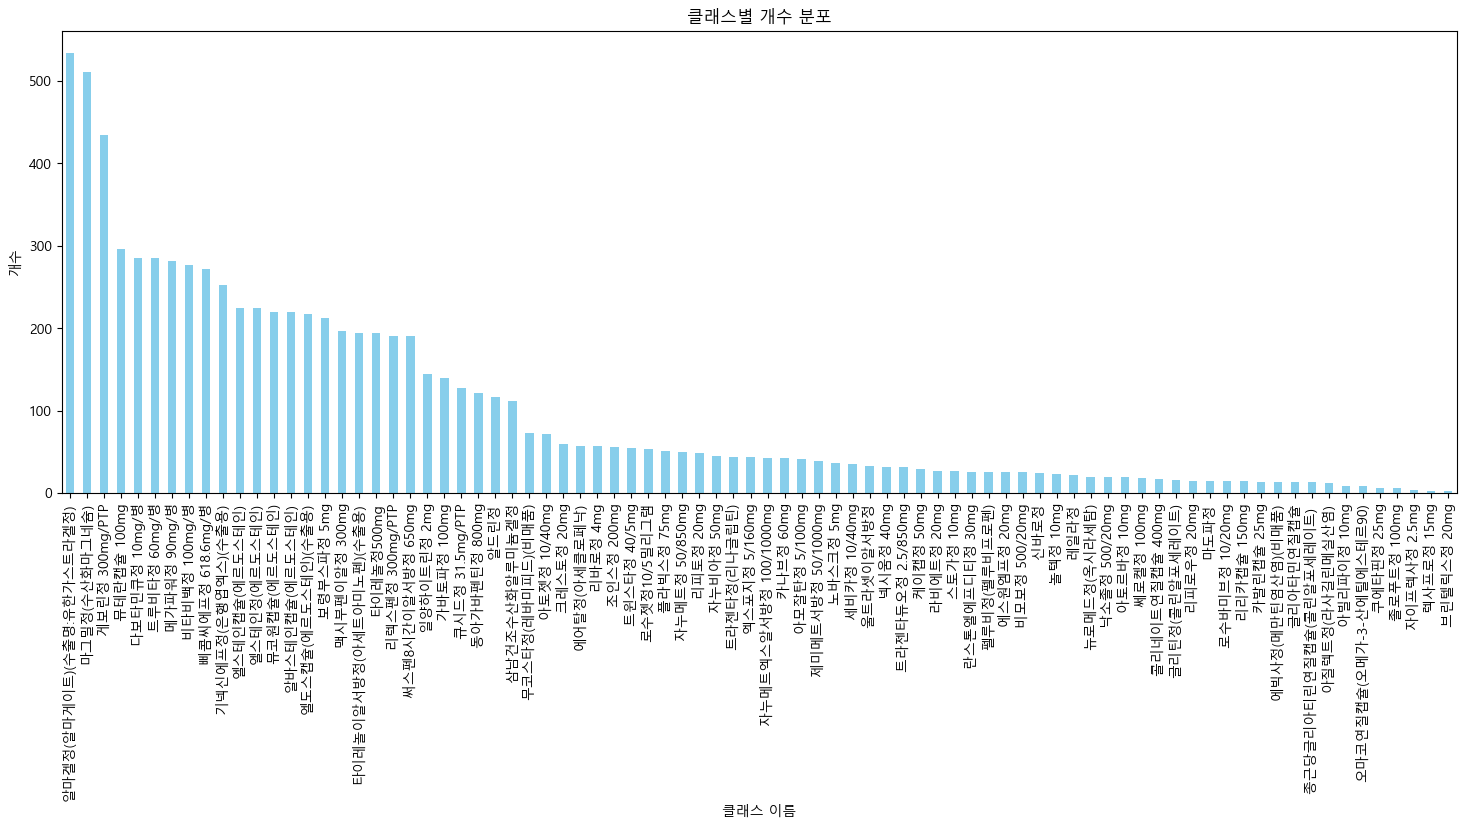

In [50]:
plt.figure(figsize=(18, 6))
class_counts.plot(kind="bar", color="skyblue")
plt.xlabel("클래스 이름")
plt.ylabel("개수")
plt.title("클래스별 개수 분포")
plt.show()

## Bounding Box 시각화

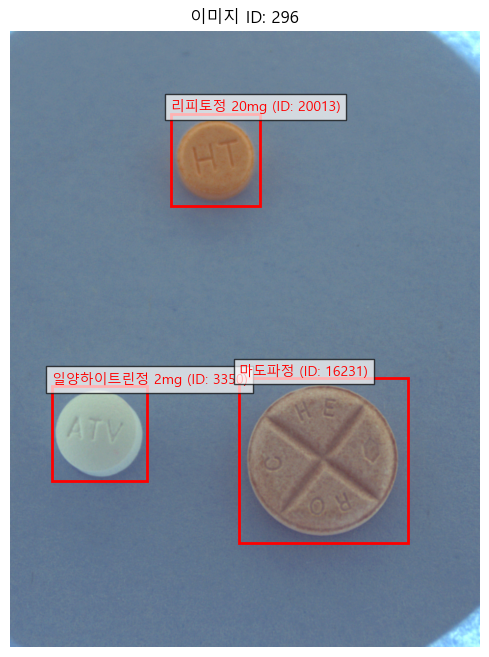

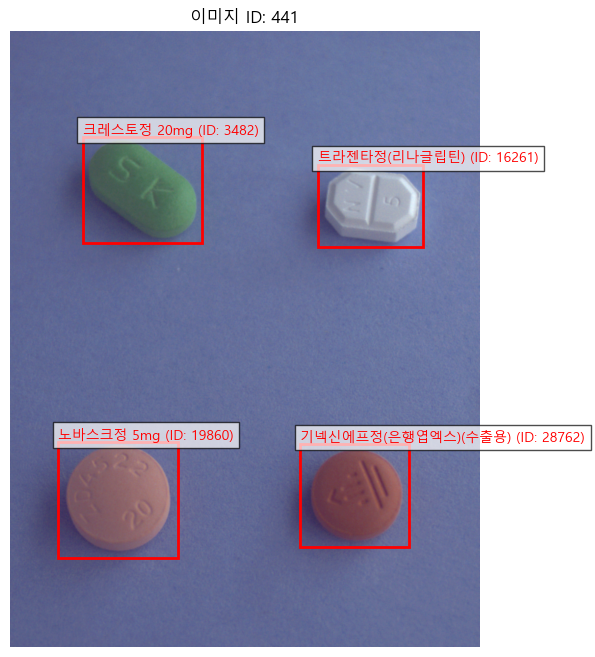

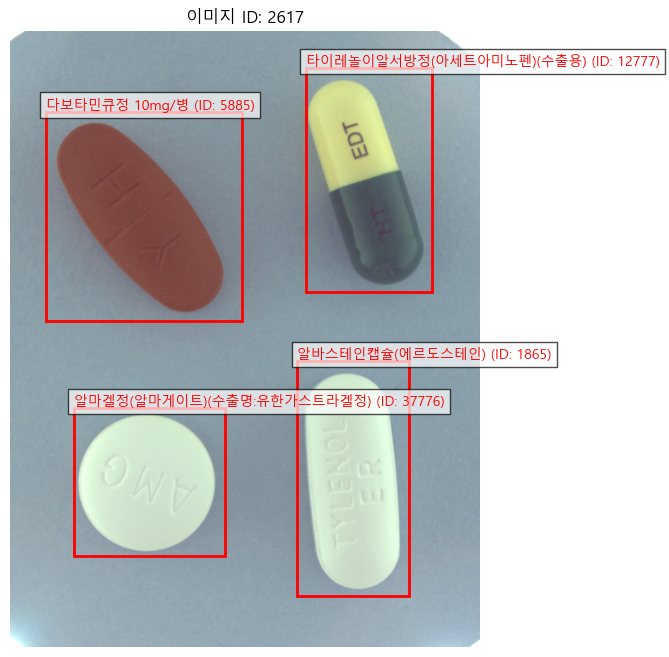

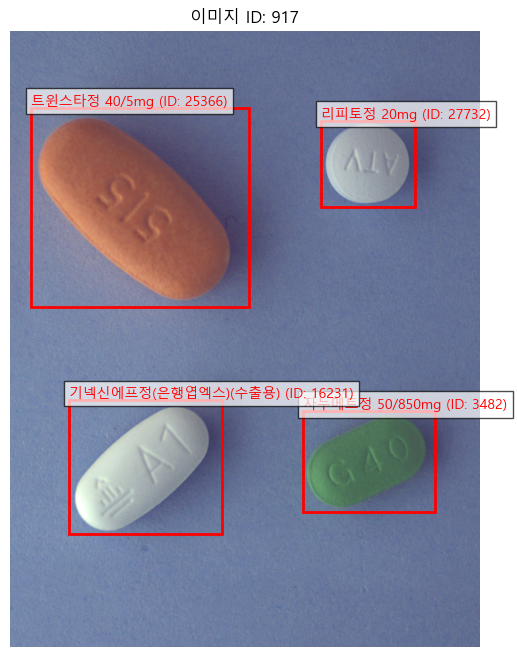

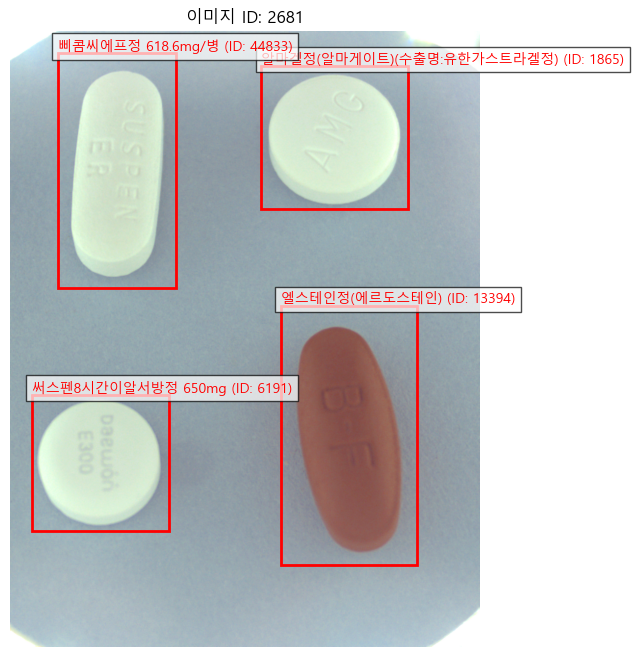

In [ ]:
import cv2

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')  # 윈도우 (맑은 고딕)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

def visualize_annotations(df, image_root_dir, num_samples=5):
    """
    이미지와 bounding box를 시각화

    Parameters:
    - df: 데이터프레임 (image_id, file_name, bbox, drug_name 포함)
    - image_root_dir: 이미지가 저장된 폴더 경로
    - num_samples: 시각화할 이미지 개수
    """
    sample_images = df.sample(n=min(num_samples, len(df)))  

    for _, row in sample_images.iterrows():
        # 이미지 경로를 폴더 경로 + 파일명으로 조합하여 로드
        image_path = os.path.join(image_root_dir, row["file_name"])

        if not os.path.exists(image_path):
            print(f"이미지를 찾을 수 없습니다: {image_path}")
            continue
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(image)

        # bounding box 그리기
        for bbox, drug_name, category_id in zip(row["bbox"], row["drug_name"], row["dl_idx"]):
            x, y, w, h = bbox
            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor="red", facecolor="none")
            ax.add_patch(rect)
            label_text = f"{drug_name} (ID: {category_id})"
            ax.text(x, y - 5, label_text, color="red", fontsize=10, bbox=dict(facecolor="white", alpha=0.7))

        ax.set_title(f"이미지 ID: {row['image_id']}")
        plt.axis("off")
        plt.show()
        
# 이미지 폴더 경로 설정
IMAGE_ROOT_DIR = "../data/train_images"

# 시각화 실행
visualize_annotations(df_grouped, IMAGE_ROOT_DIR, num_samples=5)
